# Lesson 7 - Classification and Customer Churn

> In this lesson we bring together all the knowledge we have gained about Random Forests and apply it to a new type of supervised learning task: binary classification

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson07_classification.ipynb) 
[![slides](https://img.shields.io/static/v1?label=slides&message=lesson07_classification.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=15IIYC_MksmXI6VfSL3ee-rLm7TRF0v2U)

## Learning objectives

* Know how to apply Random Forests to classification tasks
* Understand the performance metrics associated with binary classification
* Gain an introduction to fast.ai's data preprocessing functions

## References

This lesson is inspired by the following textbooks and online courses:

* Chapter 3 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* Chapter 7 of _Data Science for Business_ by Provost and Fawcett
* Lessons 1 - 4 of Jeremy Howard's fantastic online course [_Introduction to Machine Learning for Coders_](https://course18.fast.ai/ml)

You may also find the following blog post useful:

* [Grumpy, euphoric, and smart classifiers (interactive)](https://christian.bock.ml/posts/metrics/)

## Homework

* Solve the exercises included in this notebook
* Read chapter 3 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* Read chapter 7 of _Data Science for Business_ by Provost and Fawcett


## What is customer churn?

<div style="text-align: center">
<img src='images/churn.png' width='300'>
    <p style="text-align: center;"> <b>Figure reference:</b> https://s16353.pcdn.co/wp-content/uploads/2018/06/Churn.png </p>
</div>

We will explore [IBM's telecommunications dataset](https://www.kaggle.com/blastchar/telco-customer-churn) and determine which attributes are most informative for predicting customer retention (also known as customer churn). As described by IBM, the problem setting is as follows:

> A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The kind of questions we'd like to find answers to are:

* Which customers are likely to leave?
* Which attributes influence customers who leave?

## The data

As noted above, in this lesson we will analyse IBM's customer churn dataset:

* `churn.csv`

The dataset includes information about:

* Customers who left within the last month – the column is called `Churn`
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer (tenure), contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, whether they're a senior citizen or not, and if they have partners and dependents


## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment to update the library if working locally
# !pip install dslectures --upgrade

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from dslectures.core import (
    get_dataset,
    display_large,
    convert_strings_to_categories,
    rf_feature_importance,
    plot_feature_importance,
    plot_dendogram,
)
from dslectures.structured import proc_df
from pathlib import Path

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import scipy
from scipy.cluster import hierarchy as hc

## Load the data

In [ ]:
get_dataset("churn.csv")

Download of churn.csv dataset complete.


We also make use of the `pathlib` library to handle our filepaths:

In [ ]:
DATA = Path('../data/')
!ls {DATA}

churn.csv                  housing_merged.csv
churn_processed.csv        housing_processed.csv
housing.csv                submission.csv
housing_addresses.csv      test.csv
housing_gmaps_data_raw.csv train.csv


In [ ]:
churn_data = pd.read_csv(DATA / "churn.csv")

## Inspect the data

### Preview the data

Sometimes you will find that the dataset has too many columns to be displayed with the standard `DataFrame.head()` method and just shows `...` for intermediate columns:

In [ ]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


To fix that we can configure the [options in pandas](https://pandas.pydata.org/pandas-docs/version/0.15/options.html) which we can wrap inside a simple function:

In [ ]:
display_large(churn_data.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Alternatively, you can take the transpose to see all the columns more easily:

In [ ]:
churn_data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


### The shape of data

In [ ]:
# get number of rows
len(churn_data)

7043

In [ ]:
# get tuples of (n_rows, n_columns)
churn_data.shape

(7043, 21)

In this case, we see that we have 7043 customers and 21 variables or attributes that describe their telecom subscription. Let's have a look at the columns:

In [ ]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

> Note: As explained in the summary, the _**target attribute**_ is `Churn` and thus we have a _**classification problem**_ (rather than regression) because the target is a _**category**_ (Yes or No) rather than a coninuous number.

### Unique values

Whenever we see an ID column like `Id`, it is useful to perform a sanity check that each value is unique. Otherwise it may be possible that you have duplicates in your data that can bias your models and hence conclusions. 

In [ ]:
churn_data["customerID"].nunique()

7043

Good! The number of unique IDs matches the number of rows in our DataFrame.

### Data types

In [ ]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Hmm, `TotalCharges` is of type **object** (i.e. string) even though it is clearly a float. Since null values or NaNs don't produce this behaviour, there are presumably empty strings lurking in this column. Let's test this hypothesis using `DataFrame.value_counts()`:

In [ ]:
churn_data["TotalCharges"].value_counts()

20.2       11
           11
19.75       9
20.05       8
19.9        8
           ..
514.75      1
676.35      1
6510.45     1
428.45      1
6004.85     1
Name: TotalCharges, Length: 6531, dtype: int64

We will deal with this empty strings in the preprocessing steps below.

## Data preprocessing

Recall in our housing analysis, we needed to perform three main steps to bring out DataFrame to a form suitable for training a Random Forest on:

* Convert strings to categorical data type
* Fill missing values
* Numericalise the DataFrame and create a features matrix $X$ and target vector $y$
* Create train and validation sets

Let's perform each of those steps below.

### Convert strings to categories

First we convert all the string columns to pandas' categorical data type:

In [ ]:
convert_strings_to_categories(churn_data)

In [ ]:
churn_data.dtypes

customerID          category
gender              category
SeniorCitizen          int64
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges        category
Churn               category
dtype: object

This is almost correct, although a closer look at `SeniorCitizen` reveals that it refers to a binary feature and thus should also be categorical:

In [ ]:
churn_data["SeniorCitizen"].unique()

array([0, 1])

We can fix this easily by simply changing the data type:

In [ ]:
churn_data["SeniorCitizen"] = churn_data["SeniorCitizen"].astype("category")

In [ ]:
# sanity check on the transformation
churn_data.dtypes

customerID          category
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges        category
Churn               category
dtype: object

### Fill missing values

A quick way to test for missing values is to apply the `isna` method from pandas and calculate the sum of missing values in our DataFrame:

In [ ]:
(churn_data.isna().sum() / len(churn_data)).sort_values(ascending=False)

Churn               0.0
OnlineSecurity      0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineBackup        0.0
TotalCharges        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
customerID          0.0
dtype: float64

In this case, it looks like we're lucky and have a pre-cleaned dataset!

## Create feature matrix and target vector

Now that we have done some basic preprocessing, the final step is to numericalise the `pandas.DataFrame` and create the feature matrix $X$ and target vector $y$. In previous lessons we created some functions to automate these steps. Below we use fast.ai's utility function `proc_df` to wrap all these steps into a single step:

In [ ]:
X, y, nas = proc_df(churn_data, "Churn")

In [ ]:
display_large(X.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5376,1,1,2,1,1,1,2,1,1,3,1,1,1,1,1,2,3,29.85,2506
1,3963,2,1,1,1,34,2,1,1,3,1,3,1,1,1,2,1,4,56.95,1467
2,2565,2,1,1,1,2,2,1,1,3,3,1,1,1,1,1,2,4,53.85,158
3,5536,2,1,1,1,45,1,2,1,3,1,3,3,1,1,2,1,1,42.30,1401
4,6512,1,1,1,1,2,2,1,2,1,1,1,1,1,1,1,2,3,70.70,926


In [ ]:
X.shape, y.shape

((7043, 20), (7043,))

For future use we can save our processed quantities:

In [ ]:
churn_processed = X.join(pd.Series(y, name="Churn"))

churn_processed.to_csv(DATA / "churn_processed.csv", index=False)

## Create train and validation sets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"{len(X_train)} train rows + {len(X_valid)} valid rows")

5634 train rows + 1409 valid rows


## Select a performance measure

Evaluating classifiers is often significantly trickier than evaluating a regressor. One way to do this is to compare the accuracy of each classifier, where 

$$ \mbox{accuracy} = \frac{\mbox{Number of correct decisions made}}{\mbox{Total number of decisions made}} $$

In general, however, accuracy is _**not**_ the preferred performance measures for classifiers, especially when you are dealing with _**skewed datasets**_ (i.e. when some classes are much more frequent than others). For our churn example, supose we build a model that generates 75% accuracy. Is this any good? Let's have a look at the distribution of churn in the data:

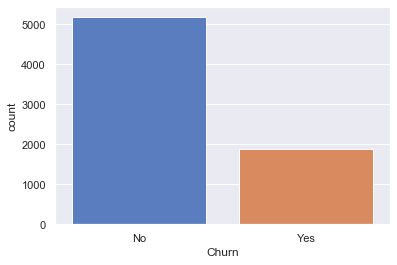

In [ ]:
sns.countplot(x="Churn", data=churn_data)
plt.show()

In [ ]:
churn_data["Churn"].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

From the plot and numbers we see that the "No Churn" and "Churn" classes appear in approximately a 3:1 ratio. If we built a dumb classifier that just classifies every single customer as "No Churn", then we would be right about 73.5% of the time! In practice skews of 99:1 are common, for which a report of 99% accuracy is somewhat meaningless.

### Confusion matrix

A much better way to evaluate the performance of a classifier is to look at the _**confusion matrix.**_ Recall that a confusion matrix for a problem involving $n$ classes is an $n\times n$ matrix with the rows labelled by the _**actual**_ classes and the columns with the _**predicted**_ classes. Our churn example is a two-class problem ("Churn" vs "No Churn"), so the confusion matrix is $2\times 2$.

If we denote the true classes as $\mathbf{p}$(positive) and $\mathbf{n}$(egative), and the classes predicted by the model as $\mathbf{Y}$(es) and $\mathbf{N}$(o) then the confusion matrix has the form:

| &nbsp; | **N** | **Y** | 
| :---: | :---: | :---: |
| **n** | True negatives | False positives | 
| **p** | False negatives | True positives |

The main diagonal contains the counts of correct decisions. The errors of the classifier are the _**false negatives**_ (positives classified as negative) and **false positives** (negatives classified as positive).

---
**You should know**

In the _Data Science for Business_ textbook, the confusion matrix is given a different layout, namely the columns a relabelled by the actual classes and the rows by the predicted classes: 

| &nbsp; | **p** | **n** | 
| :---: | :---: | :---: |
| **Y** | True positives | False positives | 
| **P** | False negatives | True negatives |

The layout adopted above and in this notebook is the one produced by scikit-learn, since we'd like to make use of the in-built functions included in that library.

---

## Baseline model

Let's begin by creating a baseline Random Forest model to build upon. First we need a scoring function for classifiers, similar to our $R^2$ and RMSE function for regression:

In [ ]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [ ]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print_scores(model)

Accuracy on train: 0.984
ROC AUC on train: 0.999
Accuracy on valid: 0.771
ROC AUC on valid: 0.801


## ROC Curves and AUC
Note that in addition to accuracy, we also show a second value, the _**Area Under the ROC Curve**_ (AUC). The AUC is a good summary statistic of the predictiveness of a binary classifier. It varies from zero to one. A value of 0.5 corresponds to randomness (the classifier cannot distinguish at all between "churn" and "no churn") and a value of 1.0 means that it is perfect.

The "ROC" refers to the Receiver Operating Characteristic (ROC) curve which plots the _true positive rate_ 

$$ \mbox{TPR} = \frac{\mbox{TP}}{\mbox{TP} + \mbox{FP}} \,, \qquad \mbox{TP (FP)}  = \mbox{number of true (false) positives}\,,$$

against the _false positive rate_ FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces. A good classifiers stays as close to the top-left corner of a ROC curve plot as possible.

In scikit-learn we can visualise the ROC curve of an estimator using the plotting API:

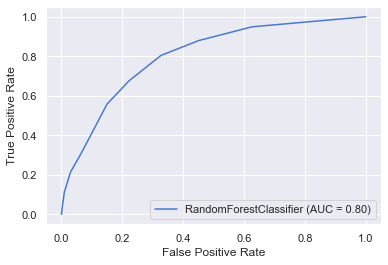

In [ ]:
plot_roc_curve(model, X_valid, y_valid)
plt.show()

Next we plot the confusion matrix using scikit-learn's plotting API:

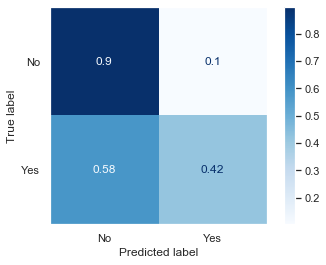

In [ ]:
# extract labels for classes
class_names = churn_data["Churn"].cat.categories

plot_confusion_matrix(
    model,
    X_valid,
    y_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize="true",
)
plt.grid(None)

From the confusion matrix we see that our baseline model is able to identify churners only 42% of the time and incorrectly classifies people who churned 58% of the time. We can do better, but first let's inspect how a single decision tree is making decisions on this data.

## Single tree

Now that we have a baseline model, let's make a single tree so we can gain some insight into how the decisions are being made:

In [ ]:
model = RandomForestClassifier(
    n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1, random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

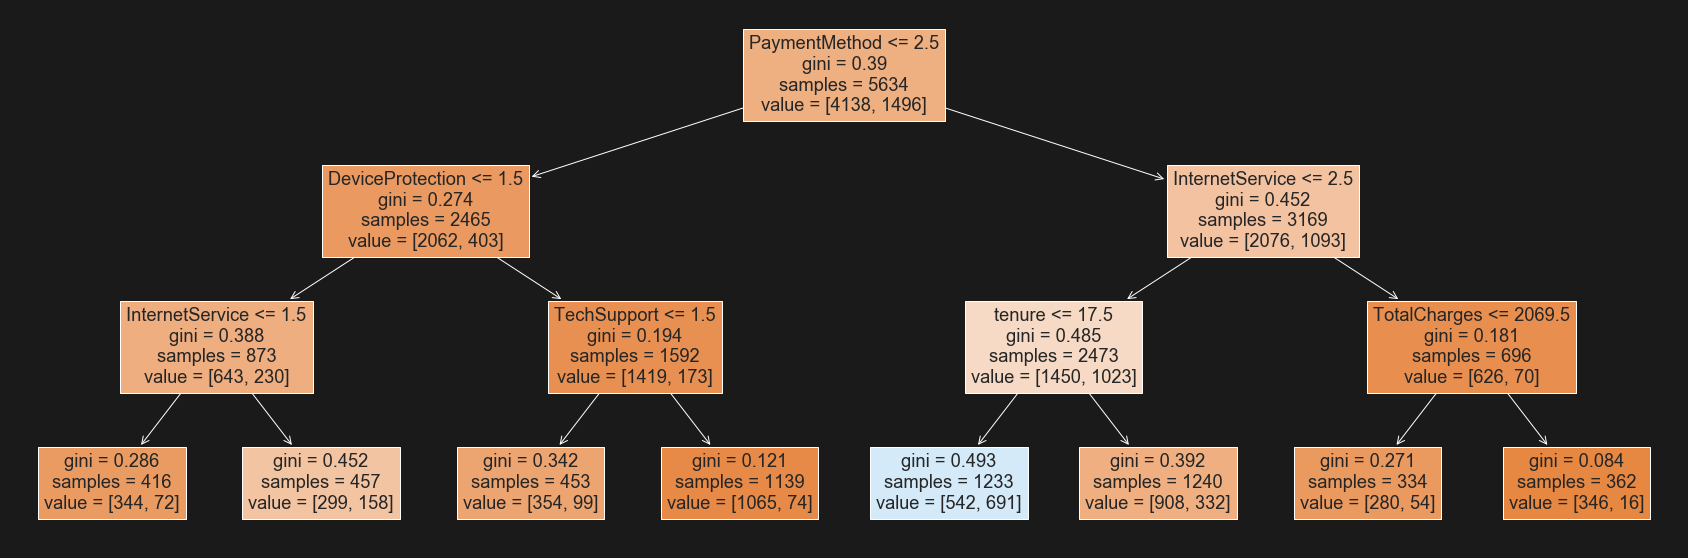

In [ ]:
# get column names
feature_names = X_train.columns
# we need to specify the background color because of a bug in sklearn
fig, ax = plt.subplots(figsize=(30, 10), facecolor="k")
# generate tree plot
plot_tree(model.estimators_[0], filled=True, feature_names=feature_names, ax=ax)
plt.show()

The main difference here compared to our housing example is that the splitting criterion is no longer the mean squared error, but instead is something known as the **_Gini index_**:

$$ G = 1 - \sum_{i=1}^n p_i^2 $$

where $p_i$ is the probability of an object being classified to a particular class (in our case "Yes" or "No"). For classification tasks, the goal is to _minimise_ the Gini index across each split, which amounts to finding which segments are most "pure".

From the figure, we can already start seeing some features that might be interesting for predicting churn, e.g. `TotalCharges`, `tenure`, and `TechSupport` seem like good indicators.

## Hyperparameter tuning

Our baseline model has an accuracy of 0.771 and ROC AUC score of 0.801 on the validation set. Let's now examine whether we can improve this by tuning the:

* number of trees in the forest
* minimum number of samples per leaf
* maximum number of features per split

In our previous lessons we manually inspected how the performance evolved when we changed these hyperparameters one at a time. Instead we can automate this process using scikit-learn's `GridSearchCV` to search for the best combination of hyperparameter values:

In [ ]:
from sklearn.model_selection import GridSearchCV

# define range of values for each hyperparameter
param_grid = [
    {
        "n_estimators": [10, 20, 40, 80, 100],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 3, 5, 10, 25],
    }
]

# instantiate baseline model
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

# initialise grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
%time grid_search.fit(X, y)

CPU times: user 2.15 s, sys: 285 ms, total: 2.44 s
Wall time: 17.3 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                     

Once the search is finished, we can get the best combination of parameters as follows:

In [ ]:
best_params = grid_search.best_params_
best_params

{'max_features': 'sqrt', 'min_samples_leaf': 25, 'n_estimators': 80}

Similarly we can get the best model in the search:

In [ ]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Let's see how this model performs on our validation set in terms of metrics and the confusion matrix:

In [ ]:
print_scores(best_model)

Accuracy on train: 0.819
ROC AUC on train: 0.876
Accuracy on valid: 0.828
ROC AUC on valid: 0.891


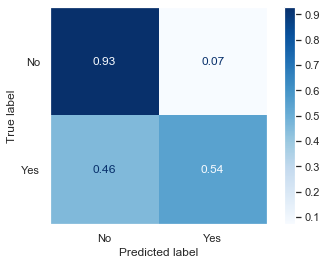

In [ ]:
plot_confusion_matrix(
    best_model,
    X_valid,
    y_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize="true",
)
plt.grid(None)

In terms of the AUC score, we see about a 10% boost over our baseline model - not bad! Our confusion matrix has also visibly improved.

## Model interpretability

As we did in the housing example, we now examine which features were deemed to be important for our Random Forest model:

In [ ]:
# expected shape - (n_features, 2)
feature_importance = rf_feature_importance(best_model, X)

# peek at top 10
feature_importance[:10]

,Column,Importance
15,Contract,0.228229
5,tenure,0.208876
9,OnlineSecurity,0.098802
18,MonthlyCharges,0.092676
12,TechSupport,0.069717
8,InternetService,0.056771
19,TotalCharges,0.049491
17,PaymentMethod,0.033299
10,OnlineBackup,0.030297
11,DeviceProtection,0.029809


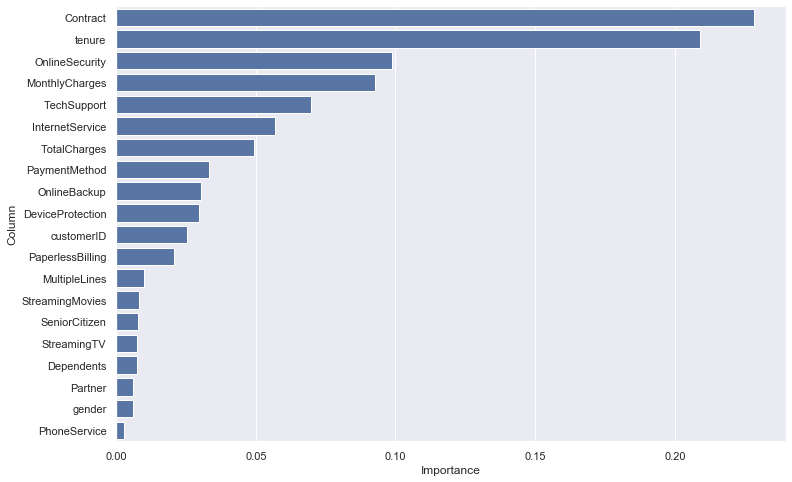

In [ ]:
plot_feature_importance(feature_importance)
plt.show()

From the plot, it seems that the feature importance flattens out around 0.005, so let's use that as a threshold to remove some uninformative features:

In [ ]:
feature_importance_threshold = 0.008
cols_to_keep = feature_importance[
    feature_importance["Importance"] > feature_importance_threshold
]["Column"]

len(cols_to_keep)

14

In [ ]:
cols_to_keep

15            Contract
5               tenure
9       OnlineSecurity
18      MonthlyCharges
12         TechSupport
8      InternetService
19        TotalCharges
17       PaymentMethod
10        OnlineBackup
11    DeviceProtection
0           customerID
16    PaperlessBilling
7        MultipleLines
14     StreamingMovies
Name: Column, dtype: object

Let's retrain with this subset and see if the score drop or not (for reference, we have accuracy of 0.807 and AUC of  0.871 on the validation set):

In [ ]:
# create a copy of the data with selected columns and create new train / test set
X_keep = X.copy()[cols_to_keep]
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["n_estimators"],
    max_features=best_params["max_features"],
    n_jobs=-1,
    oob_score=True,
    random_state=42,
)

model.fit(X_train, y_train)

print_scores(model)

Accuracy on train: 0.802
ROC AUC on train: 0.852
Accuracy on valid: 0.798
ROC AUC on valid: 0.862
OOB accuracy: 0.793


The score has not changed significantly, so let's continue and replot the feature importances:

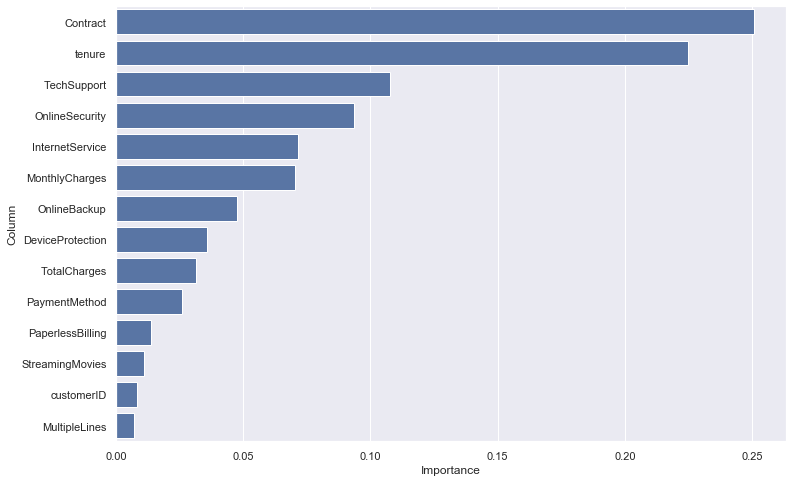

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance)
plt.show()

## One hot encoding

We can also examine whether one-hot encoding produces a better representation of the data, and hence a better model. As we did in the housing example, we need to create a new feature matrix and target vector, along with a threshold on the maximum number of categories allowed:

In [ ]:
X2, y2, nas = proc_df(churn_data, "Churn", max_n_cat=7)
X_train, X_valid, y_train, y_valid = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_jobs=-1,
    oob_score=True,
    random_state=42,
)
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.813
ROC AUC on train: 0.869
Accuracy on valid: 0.806
ROC AUC on valid: 0.863
OOB accuracy: 0.797


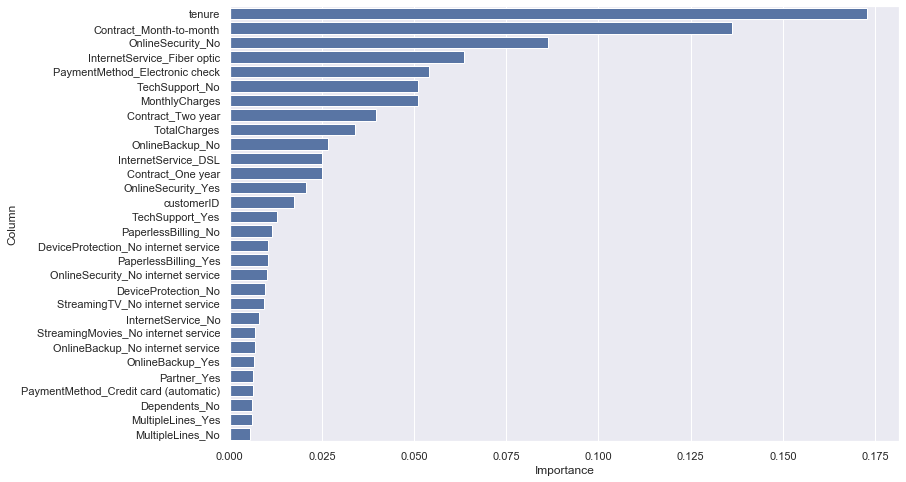

In [ ]:
feature_importance = rf_feature_importance(model, X2)
plot_feature_importance(feature_importance[:30])
plt.show()

This encoding actually gives us a slightly better model and has the added bonus of being slightly more interpretable since we can easily read off which characteristics about the customers are influencing the prediction. 

> Note: In general, you will not know in advance whether one-hot encoding will improve the performance of your model - the only way to know is to test it out eexperimentally. In our example, the increase in performance suggests that some individual categories are more predictive than the rest, thus allowing the Random Forest to focus on these features.

Let's trim the features as before and see if we can improve this model further still:

In [ ]:
feature_importance_threshold = 0.007
cols_to_keep = feature_importance[
    feature_importance["Importance"] > feature_importance_threshold
]["Column"]

len(cols_to_keep)

22

In [ ]:
# create a copy of the data with selected columns and create new train / test set
X_keep = X2.copy()[cols_to_keep]
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_jobs=-1,
    oob_score=True,
    random_state=42,
)

model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.813
ROC AUC on train: 0.871
Accuracy on valid: 0.809
ROC AUC on valid: 0.863
OOB accuracy: 0.798


OK, the model has not improved, but we have managed to reduce the number of features.

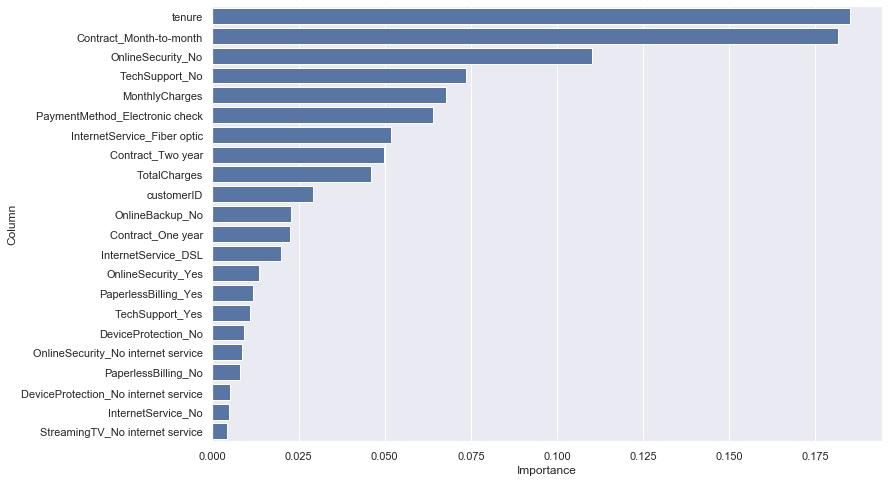

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance)
plt.show()

## Remove redundant features

We still have a lot of features to contend with, so let's see if any of them are redundant. As in the housing example, we use clustering to work out which pairs of features are "close" in some sense:

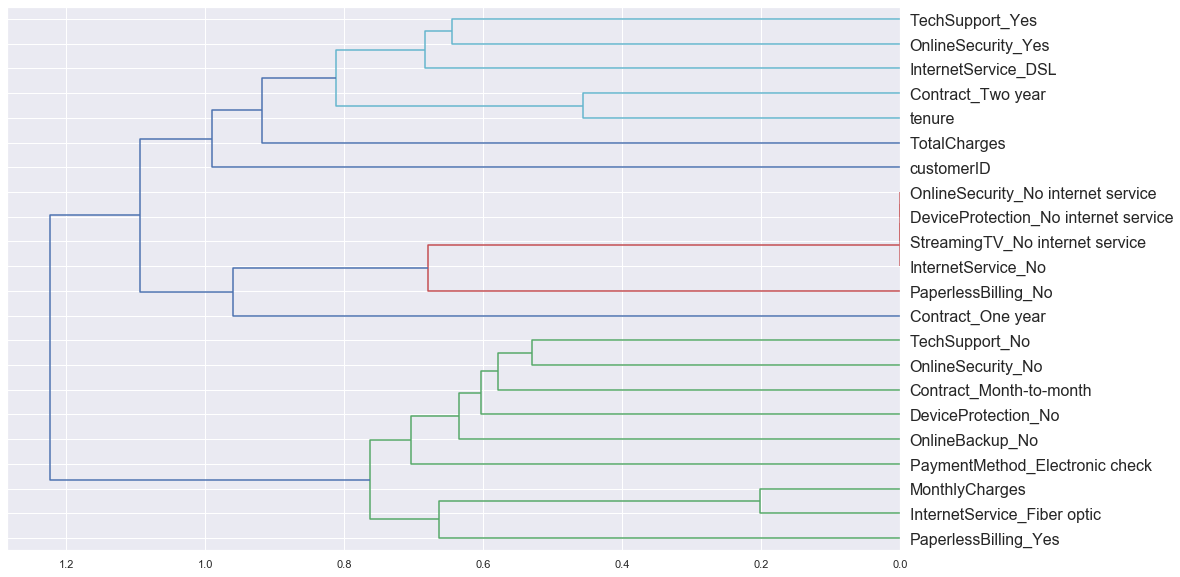

In [ ]:
plot_dendogram(X_keep)

In [ ]:
def get_oob(df):
    model = RandomForestClassifier(
        n_estimators=best_params["n_estimators"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        n_jobs=-1,
        oob_score=True,
        random_state=42,
    )
    X, _ = train_test_split(df, test_size=0.2, random_state=42)
    model.fit(X, y_train)
    return model.oob_score_

In [ ]:
get_oob(X_keep)

0.7976570820021299

In [ ]:
for c in (
    "TechSupport_Yes",
    "OnlineSecurity_Yes",
    "Contract_Two year",
    "tenure",
    "OnlineSecurity_No internet service",
    "DeviceProtection_No internet service",
    "StreamingTV_No internet service",
    "InternetService_No",
    "TechSupport_No",
    "OnlineSecurity_No",
    "MonthlyCharges",
    "InternetService_Fiber optic",
):
    print(c, get_oob(X_keep.drop(c, axis=1)))

TechSupport_Yes 0.7976570820021299
OnlineSecurity_Yes 0.7971246006389776
Contract_Two year 0.7955271565495208
tenure 0.7834575789847356
OnlineSecurity_No internet service 0.7974795882144124
DeviceProtection_No internet service 0.7974795882144124
StreamingTV_No internet service 0.7969471068512602
InternetService_No 0.7969471068512602
TechSupport_No 0.7980120695775648
OnlineSecurity_No 0.7996095136670217
MonthlyCharges 0.7946396876109336
InternetService_Fiber optic 0.7941072062477813


In [ ]:
cols_to_drop = [
    "OnlineSecurity_Yes",
    "DeviceProtection_No internet service",
    "StreamingTV_No internet service",
    "OnlineSecurity_No",
]
get_oob(X_keep.drop(cols_to_drop, axis=1))

0.7978345757898474

Good, our OOB accuracy has not changed and we've managed to remove a few features.

In [ ]:
X_keep.drop(cols_to_drop, axis=1, inplace=True)
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_jobs=-1,
    oob_score=True,
    random_state=42,
)

model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.817
ROC AUC on train: 0.873
Accuracy on valid: 0.804
ROC AUC on valid: 0.864
OOB accuracy: 0.798


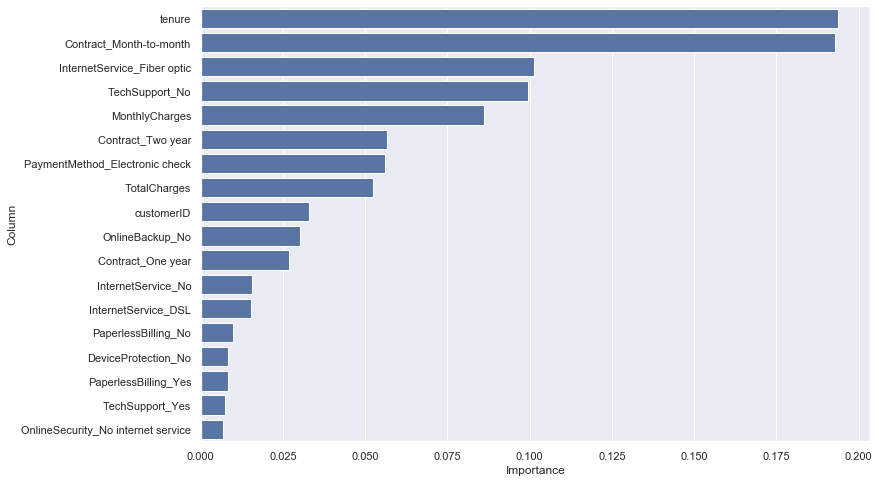

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance)
plt.show()

## Feature engineering and our final model

One thing we consistently see in our feature importance is the role of the `tenure` attribute. One way to gain a deeper insight into this attribute is to consider converting it to a categorical variable. Continuous data is often discretised or separated into "bins" for analysis. This is typically done when you want to group people into discrete age buckets or in the case of our data, discrete `tenure` buckets. Let's have a look at the distribution of `tenure` values to get an idea about how to discretise the data:

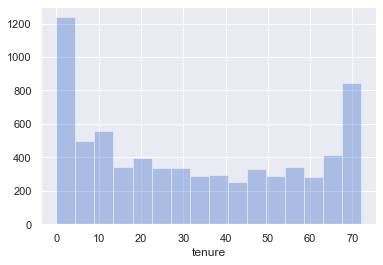

In [ ]:
sns.distplot(X_keep["tenure"], kde=False)
plt.show()

From the plot, we could reasonably divide the `tenure` values into bins of 0 to 6, 7 to 20, 21 to 40, 41 to 60, and finally 61 and over. To do so we use the `cut` function from pandas: 

In [ ]:
bins = [0, 6, 20, 40, 60, 100]
group_names = ["<=6", "7-20", "21-40", "41-60", "60+"]
X_keep["tenure_categories"] = pd.cut(
    X_keep["tenure"], bins, labels=group_names, include_lowest=True
)

Note that the object pandas returns is also a special `Categorical` object. We can also examine the value counts:

In [ ]:
X_keep["tenure_categories"].value_counts()

<=6      1481
21-40    1408
60+      1407
7-20     1397
41-60    1350
Name: tenure_categories, dtype: int64

Finally let's drop the `tenure` column since it's redundant:

In [ ]:
X_keep.drop(["tenure"], axis=1, inplace=True)

Since `tenure_cats` is a string, we also need to one-hot encode it like the rest of our features:

In [ ]:
X_keep = pd.get_dummies(X_keep)

Finally we train our model:

In [ ]:
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_jobs=-1,
    oob_score=True,
    random_state=42,
)
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.815
ROC AUC on train: 0.866
Accuracy on valid: 0.805
ROC AUC on valid: 0.861
OOB accuracy: 0.799


Although categorising the `tenure` feature did not boost performance, it does help considerably with the interpretation:

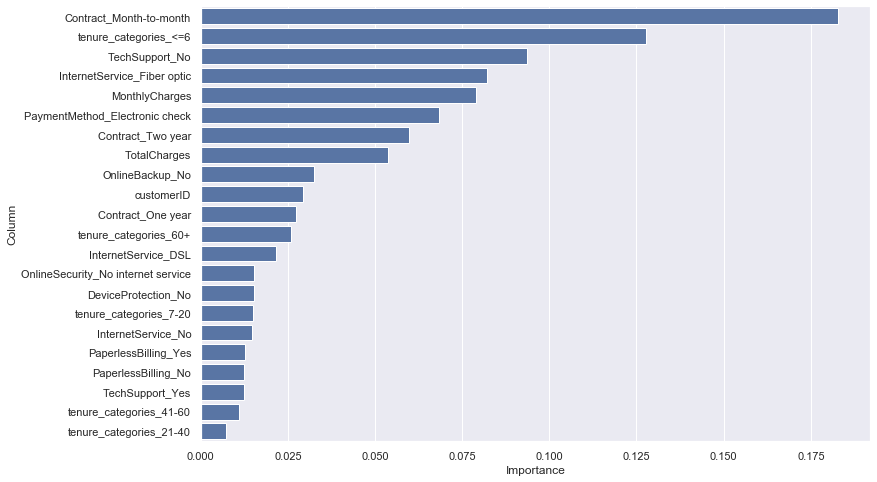

In [ ]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance)
plt.show()

From the plot we can see that the following 3 features are the most important indicators of churn:

* Customers with month to month contracts
* Customers who have been with the Telco for less than 6 months
* Customers who do not have tech support

From our analysis we could advise the client to focus on customers with these subscriptions and thereby minimise the risk that they churn.

Let's wrap up by plotting the confusion matrix of our final model:

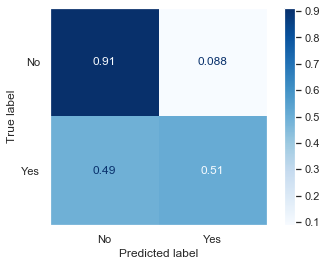

In [ ]:
plot_confusion_matrix(
    model,
    X_valid,
    y_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize="true",
)
plt.grid(None)

From this figure we can conclude that:

* If our model predicts that a customer will churn, then we can expect it to be correct 51% of the time (true positive)
* If our model predict that a customer will _not_ churn, the we can expect the prediction to be correct 91% of the time (true negative)

---

#### Exercise

Use the techniques in this lesson to solve Kaggle's famous [Titanic Challenge](https://www.kaggle.com/c/titanic). As in the housing challenge from lesson 6, the goal is not to build a perfect model, but to get familiar with building models on new datasets.

---

#### Solution

##### Load data

In [ ]:
train = pd.read_csv(DATA/'train.csv')
test = pd.read_csv(DATA/'test.csv')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


##### Data preprocessing

In [ ]:
# convert strings to categories
convert_strings_to_categories(train)
convert_strings_to_categories(test)

##### Missing values

In [ ]:
missing_values = (train.isnull().sum() / len(train)).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

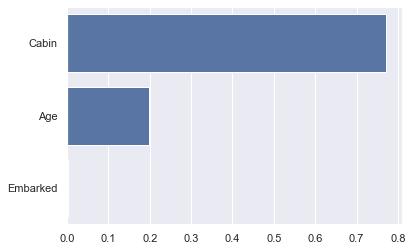

In [ ]:
sns.barplot(missing_values.values, missing_values.index, color='b');

##### Create feature matrix and target

In [ ]:
X, y, nas = proc_df(train, 'Survived')
# use NaNs from train set to fill test
test_proc, _, _ = proc_df(test, na_dict=nas)

##### Create training and validation sets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'{len(X_train)} train rows + {len(X_valid)} valid rows')

712 train rows + 179 valid rows


##### Grid search over parameters

In [ ]:
# define range of values for each hyperparameter
param_grid = [
    {
        "n_estimators": [10, 20, 40, 80, 100],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 3, 5, 10, 25],
    }
]

# instantiate baseline model
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

#
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1
)

In [ ]:
%time grid_search.fit(X, y)

CPU times: user 2.03 s, sys: 438 ms, total: 2.47 s
Wall time: 7.68 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                     

Once the search is finished, we can get the best combination of parameters as follows:

In [ ]:
best_params = grid_search.best_params_
best_params

{'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 100}

Similarly we can get the best model in the search:

In [ ]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print_scores(best_model)

Accuracy on train: 0.94
ROC AUC on train: 0.993
Accuracy on valid: 0.95
ROC AUC on valid: 0.987


##### Generate predictions on test set

In [ ]:
preds = best_model.predict(test_proc)

In [ ]:
# convert Id column to pandas.DataFrame
submission = test['PassengerId'].to_frame()
# add predictions column
submission['Survived'] = preds
# peek
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
# scores 0.74641 on Kaggle leaderboard
submission.to_csv(DATA/'submission.csv', index=False)